<a href="https://colab.research.google.com/github/AstroNoodles/Mini-Projects/blob/master/Parallel_Sync_CNN_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parallel Synchronous Gradient Descent CNN Research
In this notebook, I am led by graduate student Pengzhan Guo to create a synchronous CNN that can be parallelized between multiple supercomputers and is optimized by the best gradient descent networks (ADAM or RMSProp).

The CNN will be trained using the CiFAR dataset which will predict images out of 10 classes and multiple trials of the experiment will be done.

https://github.com/geifmany/cifar-vgg/blob/master/cifar10vgg.py

In [0]:
import numpy as np
import random
from imageio import imread
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib

NUM_CLASSES = 10
reg_factor = 1e-06 # Regularization factor for L2 Regularization


[[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 ...

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]


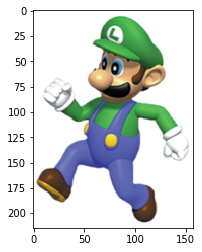

In [28]:
# DEBUG
test_img = imread('https://www.mariowiki.com/images/thumb/5/53/Luigi_Mario_Party.png/158px-Luigi_Mario_Party.png')
print(test_img[150:230])

plt.imshow(test_img)
plt.show()

# Retrieving the Datasets
This is the step where visualization and preprocessing is done in the CIFAR10 dataset that Keras gives us.

In [29]:
# DEBUG
x_train = np.arange(1, 10)
shape = tf.add(x_train, np.arange(2, 11))

with tf.compat.v1.Session() as sess:
  print(sess.run(shape[0:]))
  print(sess.run(shape[:-1]))
  print(sess.run(shape[1] // 2))

[ 3  5  7  9 11 13 15 17 19]
[ 3  5  7  9 11 13 15 17]
2


## Using The Image Data
This is from mammographic slides with SVS images rather than DICOM images

The strategy:
1. To identify breast cancer cells, you need to convert them into jpeg files or zip file
since they are too large.
2. !! USE ZIP FILES !!
3. Then, you need to set the CNN on the images and using the target, get the CNN to
predict the result
4. THE MAJOR PROBLEM: How do I save the images without using too much storage? (Many gigabytes and megabytes x 140)

In [0]:
# The Image Data
import tarfile
import zipfile
import os

def open_slides(slide_dir="."):
  for slide in os.listdir(slide_dir):
    if slide.endswith(".tar.gz"):
      print(slide)
      slide_dir_i = tarfile.open(slide)
      slide_dir_i.extractall(slide_dir)
    elif slide.endswith(".zip"):
      print(slide)
      zip_file_i = zipfile.ZipFile(slide)
      zip_file_i.extractall(slide_dir)
  
def to_np_array(image_dir=".", indicator="Output"):
  output_arr = []
  # Note that the output files should be named 'Output#'
  for item in os.listdir(image_dir):
    if os.path.isdir(item) and indicator in item:
      new_dir = os.sep.join([image_dir, item, "Output"])
      print(item)
      print(new_dir)
      for image in os.listdir(new_dir):
        im_array = imread(os.sep.join([new_dir, image]))
        no_alpha = np.delete(im_array, 1, axis=2)
        print(no_alpha.shape)
        output_arr.append(no_alpha)
  return np.array(output_arr)

In [31]:
# Get the training and testing data

open_slides()
X = to_np_array()
target = pd.read_csv('target.csv')
target['slide'] = target['slide'].str.replace(".svs", ".png")

test_target = target['target']
CIFAR = False

Output1.zip
Output1
./Output1/Output
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


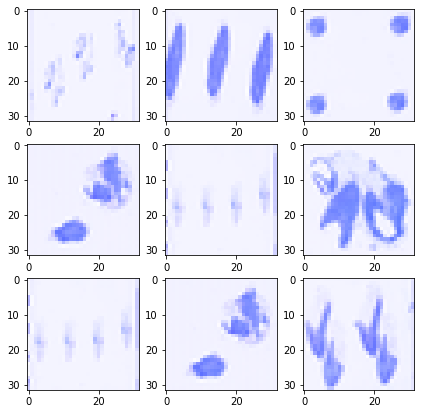

In [32]:
def visualize_cifar(train_data):
  """ Visualizes the cifar-10 dataset using matplotlib. This helps give a greater understanding
      of the items that are in the dataset"""
  plt.figure(figsize=(7, 7))
  for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(random.choice(train_data))


visualize_cifar(X)

## Examining Class Imbalance

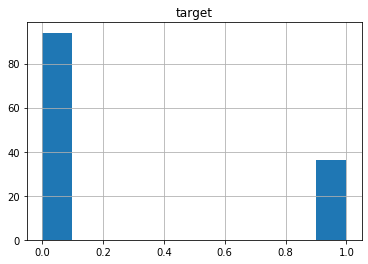

In [33]:
target.hist()
plt.show()

In [34]:
no = test_target[test_target == 0]
yes = test_target[test_target == 1]

print(f"NO CANCER has {len(no)} elements and CANCER has {len(yes)} elements")

class_weights = {0: len(no) / len(yes), 1: len(yes) / len(yes)}
print(class_weights)

NO CANCER has 16 elements and CANCER has 4 elements
{0: 4.0, 1: 1.0}


In [0]:
ids = np.arange(len(yes))
choices = np.random.choice(ids, len(no))
sample_yes = yes[choices]

(20, 32, 32, 3) (20,)
[[[[244 244 255]
   [244 244 255]
   [244 244 255]
   ...
   [243 243 255]
   [243 243 255]
   [242 243 255]]

  [[244 244 255]
   [244 244 255]
   [244 244 255]
   ...
   [243 243 255]
   [243 243 255]
   [243 243 255]]

  [[244 244 255]
   [244 244 255]
   [244 244 255]
   ...
   [243 243 255]
   [243 243 255]
   [243 243 255]]

  ...

  [[243 243 255]
   [244 244 255]
   [244 244 255]
   ...
   [243 243 255]
   [243 243 255]
   [242 242 255]]

  [[241 241 255]
   [244 244 255]
   [244 244 255]
   ...
   [243 243 255]
   [243 243 255]
   [242 242 255]]

  [[244 244 255]
   [244 244 255]
   [243 243 255]
   ...
   [243 243 255]
   [243 243 255]
   [242 242 255]]]


 [[[242 242 255]
   [242 242 255]
   [242 241 255]
   ...
   [242 242 255]
   [242 242 255]
   [242 241 255]]

  [[242 242 255]
   [242 241 255]
   [242 241 255]
   ...
   [242 242 255]
   [242 242 255]
   [242 242 255]]

  [[242 242 255]
   [242 242 255]
   [242 241 255]
   ...
   [242 242 255]
   [24

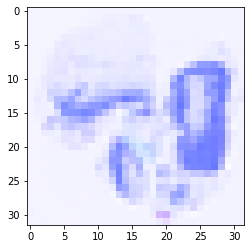

In [35]:
# Shuffle and split the data
print(X.shape, test_target.shape)
x_train, x_test, y_train, y_test = train_test_split(X, test_target, test_size=.4, 
                                                    random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=.2, random_state=42)
print(x_train)
print()
print(y_train)

plt.imshow(x_train[0])

# Preprocessing the Data

In [0]:
def smooth_label(labels, epsillion):
  """ Adds a smooth labeling to all the one-hot encoded labels to prevent overfitting
      in the dataset: https://tinyurl.com/kerastricks"""
  if 0 <= epsillion <= 1:
    labels *= (1.0 - epsillion)
    labels += (epsillion / labels.shape[1])
  else:
    raise Exception("Label smoothing factor should be between 0 and 1. Your factor is: " + str(epsillion))
  
  return labels
  

In [0]:
def normalize_data(x_train, x_test):
  """ Normalizes the data by dividing by subtracting the mean 
      and dividing by the standard deviation. Akin to scikit-learn's
      StandardScaler."""
  mean_train, mean_test = np.mean(x_train), np.mean(x_test)
  std_train, std_test = np.std(x_train), np.std(x_test)
  return ((x_train - mean_train) / std_train, (x_test - mean_test) / std_test)
  

And now, we prepare the data for preprocessing!

In [38]:
# ONLY FOR BREAST CANCER SLIDES
NUM_CLASSES = 2
BATCH_SIZE = 32

x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train, x_test = normalize_data(x_train, x_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
smooth_label(y_train, 0.2)

print(x_train, x_train.shape, y_train, y_train.shape)

# Preprocessing the image dataset by artificially increasing the training data size
# via rescaling, shifting, flipping and rotating the dataset.
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    rotation_range=180,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    width_shift_range=.5,
    height_shift_range=.5,
    horizontal_flip=True,
    vertical_flip=True)

data_gen.fit(x_train)

[[[[ 0.2982808   0.2982808   0.63029623]
   [ 0.2982808   0.2982808   0.63029623]
   [ 0.2982808   0.2982808   0.63029623]
   ...
   [ 0.26809758  0.26809758  0.63029623]
   [ 0.26809758  0.26809758  0.63029623]
   [ 0.23791437  0.26809758  0.63029623]]

  [[ 0.2982808   0.2982808   0.63029623]
   [ 0.2982808   0.2982808   0.63029623]
   [ 0.2982808   0.2982808   0.63029623]
   ...
   [ 0.26809758  0.26809758  0.63029623]
   [ 0.26809758  0.26809758  0.63029623]
   [ 0.26809758  0.26809758  0.63029623]]

  [[ 0.2982808   0.2982808   0.63029623]
   [ 0.2982808   0.2982808   0.63029623]
   [ 0.2982808   0.2982808   0.63029623]
   ...
   [ 0.26809758  0.26809758  0.63029623]
   [ 0.26809758  0.26809758  0.63029623]
   [ 0.26809758  0.26809758  0.63029623]]

  ...

  [[ 0.26809758  0.26809758  0.63029623]
   [ 0.2982808   0.2982808   0.63029623]
   [ 0.2982808   0.2982808   0.63029623]
   ...
   [ 0.26809758  0.26809758  0.63029623]
   [ 0.26809758  0.26809758  0.63029623]
   [ 0.23791437 

# Building The Model
The models were built by using a combination of methods from the Inceptionv3 model and the VGGNet models that are on Github. The layers used are given in the imports in the first code cell.

In [39]:
def cifar_net(reg_factor):
    model = tf.keras.models.Sequential()

    # Layer 1
    model.add(tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer=tf.keras.initializers.he_normal(), 
                                     input_shape=(32, 32, 3),
    padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())


    model.add(tf.keras.layers.MaxPooling2D(2, 2))

    # Layer 2
    model.add(tf.keras.layers.Conv2D(256, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256, 1, padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())


    model.add(tf.keras.layers.Conv2D(256, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Dropout(.2))

    # Layer 3
    model.add(tf.keras.layers.Conv2D(512, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.MaxPooling2D(2, 2))

    # Layer 4
    model.add(tf.keras.layers.Conv2D(1024, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(1024, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.MaxPooling2D(2, 2))


    # Layer 5
    model.add(tf.keras.layers.Conv2D(2056, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(2056, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())


    model.add(tf.keras.layers.MaxPooling2D(1, 1))
    model.add(tf.keras.layers.Dropout(.2))

    #   Layer 6
    #   model.add(tf.keras.layers.Flatten())
    #   model.add(tf.keras.layers.Dense(2056, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    #   model.add(tf.keras.layers.Activation('relu'))
    #   # model.add(tf.keras.layers.BatchNormalization())

    #   # Layer 7
    #   model.add(tf.keras.layers.Dense(2056, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    #   model.add(tf.keras.layers.Activation('relu'))
    #   # model.add(tf.keras.layers.BatchNormalization())

    #   # Layer 8
    #   model.add(tf.keras.layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    #   model.add(tf.keras.layers.Activation('relu'))
    #   model.add(tf.keras.layers.BatchNormalization())
    #   model.add(tf.keras.layers.Dropout(.2))

    # Layer 9
    model.add(tf.keras.layers.AveragePooling2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(NUM_CLASSES))
    model.add(tf.keras.layers.Activation('softmax'))

    return model
no

2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
19    0
Name: target, dtype: int64

In [0]:
def cancer_net(output_bias=None, reg_factor=.4):
    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)
    
    
    model = tf.keras.models.Sequential(name="Breast Cancer Net")

    # Layer 1
    model.add(tf.keras.layers.Conv2D(8, (3, 3), kernel_initializer=tf.keras.initializers.he_normal(), 
                input_shape=(32, 32, 3), kernel_constraint=tf.keras.constraints.max_norm(1, axis=[0, 1, 2]),
    padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
 #   model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('elu'))

    model.add(tf.keras.layers.MaxPooling2D(2, 2))

    # Layer 2
    model.add(tf.keras.layers.Conv2D(16, (3, 1), padding="same", kernel_constraint=tf.keras.constraints.max_norm(1, axis=[0, 1, 2]), kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  #  model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('elu'))

    model.add(tf.keras.layers.MaxPooling2D(2, 2))

    # Layer 3
    model.add(tf.keras.layers.Conv2D(16, (1, 3), padding="same", kernel_constraint=tf.keras.constraints.max_norm(1, axis=[0, 1, 2]), kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('elu'))

   # model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Dropout(.3))

    # Layer 4
    model.add(tf.keras.layers.Conv2D(32, (3, 1), padding="same", kernel_constraint=tf.keras.constraints.max_norm(1, axis=[0, 1, 2]),  kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
 #   model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('elu'))

    model.add(tf.keras.layers.MaxPooling2D(2, 2))

    # Layer 5
    model.add(tf.keras.layers.Conv2D(32, (1, 3), padding="same", kernel_constraint=tf.keras.constraints.max_norm(1, axis=[0, 1, 2]), kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('elu'))



    model.add(tf.keras.layers.Conv2D(32, (3, 1), padding="same", kernel_constraint=tf.keras.constraints.max_norm(1, axis=[0, 1, 2]),  kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
 #   model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(.5))

    model.add(tf.keras.layers.MaxPooling2D(2, 2))

      #Layer 6
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, kernel_constraint=tf.keras.constraints.max_norm(1, axis=0), kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.Activation('relu'))
   # model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dropout(.4))

    # Layer 8
    model.add(tf.keras.layers.Dense(128, kernel_constraint=tf.keras.constraints.max_norm(1, axis=0), kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.Activation('relu'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(.3))

    # Layer 9
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(NUM_CLASSES, bias_initializer=output_bias) )
    model.add(tf.keras.layers.Activation('sigmoid'))

    return model


Now, we print the models to see their summary and number of parameters in each.

In [41]:
output_bias = np.log([len(yes) / len(no)])
print(output_bias)

model2 = cancer_net(output_bias)
model2.summary()
print()

[-1.38629436]
Model: "Breast Cancer Net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 16)        400       
_________________________________________________________________
activation_19 (Activation)   (None, 16, 16, 16)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None,

# Executing the Model
Now, the model built above will be executed with the training set. If there are more than one GPUs on the computer this file is being called in, then it will parallelize the model between the GPUs, else it will execute on the one GPU and CPU. 

In [42]:
print(tf.keras.__version__)
devices = device_lib.list_local_devices()
learning_rate = 1e-3
decay_rate = 1
gpus = [devices[i].device_type in devices for (i, device) in enumerate(devices) if "GPU" in devices[i].device_type]
print(gpus)

T = len(x_train) // len(gpus)
print(T)
isParallel = any(gpus)

2.2.4-tf
[False, False]
4


In [0]:
def schedule_lr(epoch, lr):
  return 1 / (1 + decay_rate * epoch) * learning_rate

schedule_lr = tf.keras.callbacks.LearningRateScheduler(schedule_lr, verbose=1)

In [0]:
def results_to_file(results, file_name="test.txt"):
  if not results:
    raise TypeError('No dictionary to save to file')
  with open(file_name, 'w+') as file:
    print(str(results), file=file)
  print('Success saving to file!')

In [65]:
optimizer = tf.keras.optimizers.SGD(lr=learning_rate, momentum=0.9, 
                                    nesterov = True)
EPOCHS = 300
BATCH_SIZE = 128

history = None
print(y_test)
if isParallel:
  print('GPUs parallelized!')
  model2 = tf.keras.utils.multi_gpu_model(model2, 2)
  model2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=
                 [tf.keras.metrics.Precision(name = 'precision'), tf.keras.metrics.AUC(name="auc"), 
                  tf.keras.metrics.BinaryAccuracy(name="binary_acc"), tf.keras.metrics.Recall(name='recall')])
  
  history = multi_gpu_model.fit_generator(data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                      steps_per_epoch=(x_train.shape[0] // BATCH_SIZE), epochs=EPOCHS,
                      validation_data=(x_val, y_val), class_weight=class_weights)
  results_to_file(history.history, 'model2-l2perfect=' + str(reg_factor) + '.txt')
else:
  print('CPU Compilation')

  model2.compile(optimizer=optimizer, loss="binary_crossentropy",
                metrics=[tf.keras.metrics.Precision(name = 'precision'), tf.keras.metrics.AUC(name="auc"), 
                         tf.keras.metrics.BinaryAccuracy(name="binary_acc"), tf.keras.metrics.Recall(name='recall')])
  
  history = model2.fit_generator(data_gen.flow(x_train, y_train, batch_size=test_batch),
                      steps_per_epoch=(x_train.shape[0] // test_batch), epochs=EPOCHS,
                      validation_data=(x_test, y_test), class_weight=class_weights)
  results_to_file(history.history, 'model2perfect.txt')

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
CPU Compilation
Epoch 1/6
2/2 [==============================] - 3s 1s/step - loss: 145.5569 - precision: 1.0000 - auc: 0.0000e+00 - binary_acc: 0.0000e+00 - recall: 0.1000 - val_loss: 142.3969 - val_precision: 0.0000e+00 - val_auc: 0.5625 - val_binary_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 2/6
2/2 [==============================] - 2s 989ms/step - loss: 143.9591 - precision: 1.0000 - auc: 0.0000e+00 - binary_acc: 0.0000e+00 - recall: 0.2000 - val_loss: 140.6922 - val_precision: 0.0000e+00 - val_auc: 0.4844 - val_binary_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 3/6
2/2 [==============================] - 2s 1s/step - loss: 140.9899 - precision: 1.0000 - auc: 0.0000e+00 - binary_acc: 0.0000e+00 - recall: 0.5000 - val_loss: 138.4907 - val_precision: 0.0000e+00 - val_auc: 0.4531 - val_binary_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 4/6
2/2 [==============================] - 2s 1s/step - loss: 138.4761 - precisi

# Analyzing Results
Currently, the best results give a constant validation binary accuracy of .7564.

In [66]:
main_results = model2.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=1)
for metric, result in zip(model2.metrics_names, main_results):
  print(metric, " : ", result)

9/9 [==============================] - 0s 641us/sample - loss: 129.7152 - precision: 0.0000e+00 - auc: 0.0000e+00 - binary_acc: 0.0000e+00 - recall: 0.0000e+00
loss  :  129.71524047851562
precision  :  0.0
auc  :  0.0
binary_acc  :  0.0
recall  :  0.0


In [0]:
def plot_curve(train_data, test_data, figname, title, ylabel):
  plt.clf()
  plt.plot(train_data)
  plt.plot(test_data)
  plt.xlabel('Epoch')
  plt.ylabel(ylabel)
  plt.title(title)
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.savefig(figname)

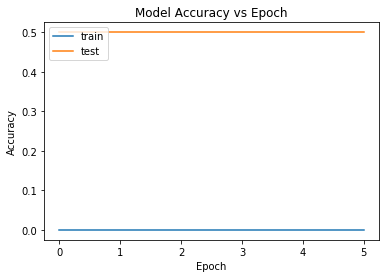

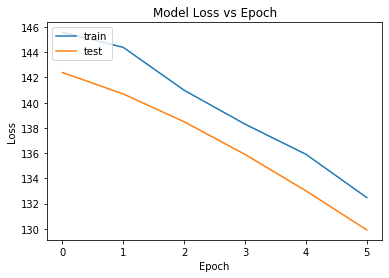

<Figure size 432x288 with 0 Axes>

In [68]:
plot_curve(history.history['binary_acc'], 
           history.history['val_binary_acc'], 'model2acc.png', 
           'Model Accuracy vs Epoch', 
          'Accuracy')
plot_curve(history.history['loss'], 
           history.history['val_loss'], 'model2loss.png',
           'Model Loss vs Epoch', 'Loss')